# Partial Differential Equations solved using PINNs.


### 1. Defining a few functions and initial, boundaries, eqns and stuff.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn

### 1. Defining the initial arrays of space and time.

In [ ]:
Nx = 20
Nt = 20
Nv = 20

k = 0.4
L = (2 * np.pi) / k

x = torch.linspace(0, L, Nx).view(-1, 1)  #[Nx]
v = torch.linspace(-6, 6, Nv).view(-1, 1) #[Nv]
t = torch.linspace(0, 5, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape} and v : {v.shape}")


Shape of x : torch.Size([20, 1]) and t : torch.Size([20, 1]) and v : torch.Size([20, 1])


In [ ]:
# Meshes and vectors
X_train, v_train, t_train = torch.meshgrid(x.squeeze(), v.squeeze() ,t.squeeze(), indexing='xy')

X_train, v_train, t_train = X_train.reshape(-1, 1), v_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape} and v_train : {v_train.shape}")

Shape of X_train : torch.Size([8000, 1]) and t_train : torch.Size([8000, 1]) and v_train : torch.Size([8000, 1])


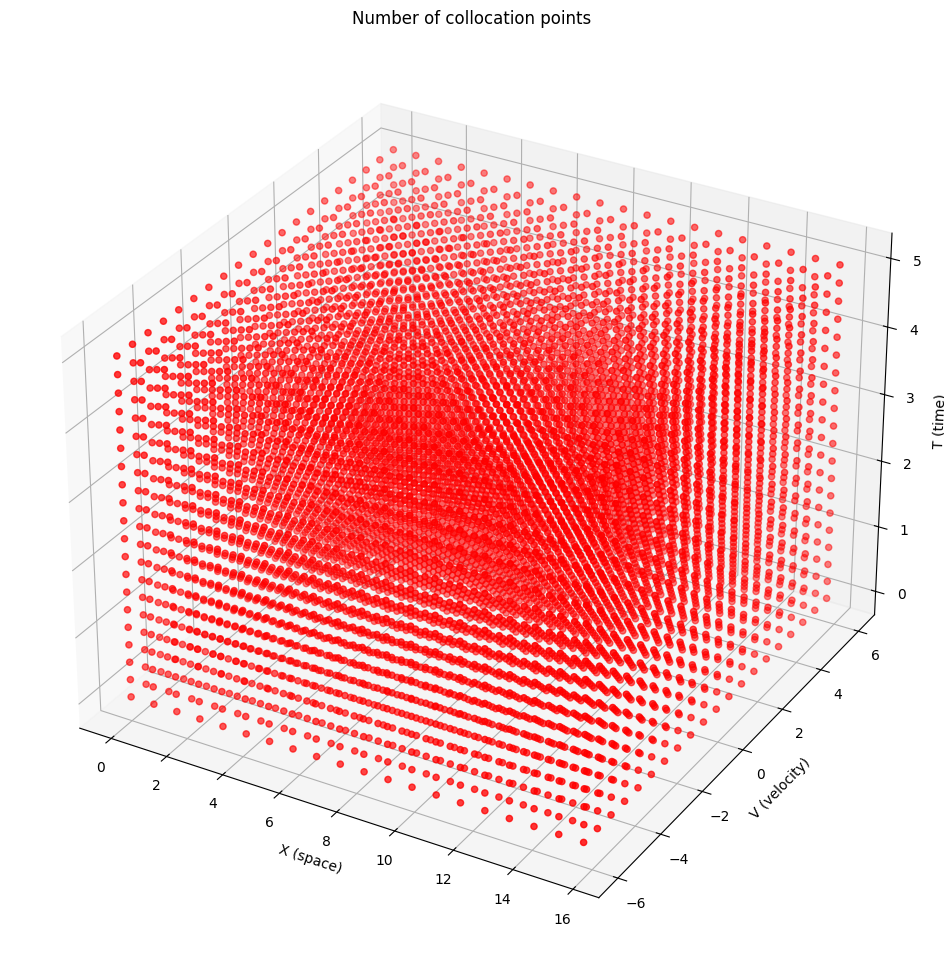

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train, v_train, t_train, c='r', marker='o')
ax.set_xlabel('X (space)')
ax.set_ylabel('V (velocity)')
ax.set_zlabel('T (time)')
ax.set_title('Number of collocation points')
plt.show()

### 2. Neural network architecture.

In [ ]:
class VlasovPINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.SiLU

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, v, t):
    inputs = torch.cat([x, v, t], dim=1)
    outputs = self.net(inputs)

    q = outputs

    return q



class PoissonPINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.SiLU

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, t):
    inputs = torch.cat([x, t], dim=1)
    outputs = self.net(inputs)

    E = outputs

    return E





### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [ ]:
def Vlasov_PDE_loss(q_pred, E, x_train, v_train, t_train):
  """
  Vlassov : dQ_dt + (V * dQ_dx) + (a * dQ_dv) = 0
  Poisson : dE_dx - integral(Q, dv) + 1 = 0
  IC : Q(x, v, t=0) = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x)) | E(x, v, t=0) = (alpha/k) * torch.cos(k * x)
  BC : Q is period

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dv = torch.autograd.grad(q_pred, v_train, torch.ones_like(q_pred), create_graph=True)[0]

  #eqn1 = dQ_dt + (v * dQ_dx) + (E * dQ_dv)
  eqn1 = dQ_dt + (v_train * dQ_dx) - (E * dQ_dv) #Vlassov
  return torch.mean(eqn1**2)


def Vlasov_initial_condition_loss(q_pred, x, v, t, alpha = 0.01):
  initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x))      #No use of v or t here, this is the initial condition.

  return torch.mean((q_pred-initial_condition_Q) ** 2)


def Vlasov_boundary_condition_loss(qlb_pred, qup_pred, t):
  lb, ub = torch.zeros_like(t), torch.zeros_like(t) # Lb = 0, Ub = 0. Both of the same shape as t.

  return torch.mean((qup_pred - qlb_pred) ** 2) # Periodic along x axis and v axis.

In [ ]:
def Poisson_PDE_loss(E_pred, rho, x_train, v_train, t_train):
  """
  Vlassov : dQ_dt + (V * dQ_dx) + (a * dQ_dv) = 0
  Poisson : dE_dx - integral(Q, dv) + 1 = 0
  IC : Q(x, v, t=0) = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x)) | E(x, v, t=0) = (alpha/k) * torch.cos(k * x)
  BC : Q is period

  Finds physics loss based on the above equation.
  """
  dE_dx = torch.autograd.grad(E_pred, x_train, torch.ones_like(E_pred), create_graph=True)[0]
  dE_dxdv = torch.autograd.grad(dE_dx, v_train, torch.ones_like(dE_dx), create_graph=True)[0]


  eqn1 = dE_dx + rho - 1
  # eqn1 = dE_dxdv + rho # Poisson
  return torch.mean(eqn1**2)


def Poisson_initial_condition_loss(E_pred, x, t, alpha = 0.01):
  initial_condition_E = (alpha/k) * torch.cos(k * x)      #No use of v or t here, this is the initial condition.

  return torch.mean((E_pred-initial_condition_E) ** 2)


def Poisson_boundary_condition_loss(Elb_pred, Eub_pred, t):

  return torch.mean((Eub_pred - Elb_pred) ** 2) # Periodic along x axis.

### 4. Writing the training loop.

In [ ]:
VlasovPINN = VlasovPINN(3, 64, 4, 1)
Vlasov_optimiser = torch.optim.Adam(VlasovPINN.parameters(), lr = 0.01)

PoissonPINN = PoissonPINN(2, 64, 4, 1)
Poisson_optimiser = torch.optim.Adam(PoissonPINN.parameters(), lr = 0.01)

epochs = 1000

In [ ]:
X_train_Vlasov = X_train.requires_grad_(True)
t_train_Vlasov = t_train.requires_grad_(True)
v_train_Vlasov = v_train.requires_grad_(True)

X_train_Poisson = X_train.requires_grad_(True)
v_train_Poisson = v_train.requires_grad_(True)
t_train_Poisson = t_train.requires_grad_(True)

In [ ]:
TOTAL_LOSS_VLASOV, TOTAL_LOSS_POISSON = [], []
alpha = 0.01
e_pred = (alpha/k) * torch.cos(k * X_train_Poisson)

In [ ]:
for epoch in range(1, epochs+1):
  VlasovPINN.train()
  PoissonPINN.train()

  Vlasov_optimiser.zero_grad()
  Poisson_optimiser.zero_grad()

  # Vlasov equation - solver 1
  # Initial Condition

  q_pred_init  = VlasovPINN(x, v, torch.zeros_like(x)) # q(x, v, 0)
  Vlasov_ic_loss = Vlasov_initial_condition_loss(q_pred_init, x, v, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred1  = VlasovPINN(torch.full_like(t, 0), v, t) # q(0, v, t) - lower bound at x=0
  q_ub_pred1 = VlasovPINN(torch.full_like(t, L), v, t) # q(16, v, t) - upper bound at x=16
  Vlasov_bcloss1 = Vlasov_boundary_condition_loss(q_lb_pred1, q_ub_pred1, t)

  q_lb_pred2 = VlasovPINN(x, torch.full_like(t, -6), t) # q(x, -6, t) - lower bound at v=-6
  q_ub_pred2 = VlasovPINN(x, torch.full_like(t, 6), t) # q(x, 6, t) - upper bound at v=6
  Vlasov_bcloss2 = Vlasov_boundary_condition_loss(q_lb_pred2, q_ub_pred2, t)

  Vlasov_bc_loss = Vlasov_bcloss1 + Vlasov_bcloss2

  # Physics Condition
  q_pred = VlasovPINN(X_train_Vlasov, v_train_Vlasov, t_train_Vlasov)
  e_pred = e_pred.detach()
  Vlasov_physics_loss = Vlasov_PDE_loss(q_pred, e_pred, X_train_Vlasov, v_train_Vlasov, t_train_Vlasov)

  # torch.autograd.set_detect_anomaly(True)

  # Total loss
  Vlasov_total_loss = Vlasov_physics_loss + Vlasov_ic_loss + Vlasov_bc_loss
  Vlasov_total_loss.backward()
  Vlasov_optimiser.step()

  TOTAL_LOSS_VLASOV.append(Vlasov_total_loss.item())

  q_copy = q_pred.detach()
  v_copy = v_train_Vlasov.detach()
  rho = torch.trapz(q_copy, v_copy)

  # Poisson equation - solver 2
  # Initial Condition

  e_pred_init  = PoissonPINN(x, torch.zeros_like(x)) # e(x, 0)
  Poisson_ic_loss = Poisson_initial_condition_loss(e_pred_init, x, torch.zeros_like(x))

  # Boundary Condition
  e_lb_pred  = PoissonPINN(torch.full_like(t, 0), t) # e(0, t) - lower bound at x=0
  e_ub_pred = PoissonPINN(torch.full_like(t, L), t) # e(L, t) - upper bound at x=16
  Poisson_bc_loss = Poisson_boundary_condition_loss(e_lb_pred, e_ub_pred, t)

  # Physics Condition
  e_pred = PoissonPINN(X_train_Poisson, t_train_Poisson) # e(x, t)
  Poisson_physics_loss = Poisson_PDE_loss(e_pred, rho, X_train_Poisson, v_train_Poisson, t_train_Poisson)

  # Total loss
  Poisson_total_loss = Poisson_physics_loss + Poisson_ic_loss + Poisson_bc_loss

  Poisson_total_loss.backward()
  Poisson_optimiser.step()

  TOTAL_LOSS_POISSON.append(Poisson_total_loss.item())


  if(epoch%1==0):
    print(f"Vlasov [{epoch}/{epochs}] Losses - Total:{Vlasov_total_loss.item():.4f}, Physics:{Vlasov_physics_loss.item():.4f}, IC:{Vlasov_ic_loss.item():.4f}, BC:{Vlasov_bc_loss.item():.4f} || Poisson [{epoch}/{epochs}] Losses - Total:{Poisson_total_loss.item():.4f}, Physics:{Poisson_physics_loss.item():.4f}, IC:{Poisson_ic_loss.item():.4f}, BC:{Poisson_bc_loss.item():.4f}")


Vlasov [1/1000] Losses - Total:1.1779, Physics:0.0464, IC:0.2973, BC:0.8342 || Poisson [1/1000] Losses - Total:1.0007, Physics:0.9947, IC:0.0043, BC:0.0018
Vlasov [2/1000] Losses - Total:0.0243, Physics:0.0006, IC:0.0137, BC:0.0101 || Poisson [2/1000] Losses - Total:1.7394, Physics:1.0818, IC:0.2385, BC:0.4192
Vlasov [3/1000] Losses - Total:0.0474, Physics:0.0013, IC:0.0198, BC:0.0263 || Poisson [3/1000] Losses - Total:1.0415, Physics:0.9673, IC:0.0048, BC:0.0693
Vlasov [4/1000] Losses - Total:0.0289, Physics:0.0005, IC:0.0189, BC:0.0095 || Poisson [4/1000] Losses - Total:1.0104, Physics:0.9807, IC:0.0062, BC:0.0235
Vlasov [5/1000] Losses - Total:0.0327, Physics:0.0010, IC:0.0169, BC:0.0147 || Poisson [5/1000] Losses - Total:1.0219, Physics:1.0117, IC:0.0018, BC:0.0084
Vlasov [6/1000] Losses - Total:0.0197, Physics:0.0008, IC:0.0148, BC:0.0042 || Poisson [6/1000] Losses - Total:1.0133, Physics:1.0084, IC:0.0008, BC:0.0041
Vlasov [7/1000] Losses - Total:0.0287, Physics:0.0014, IC:0.0174

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(TOTAL_LOSS_VLASOV)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Vlasov loss vs epochs")
ax[0].axhline(0.0, c='gray', linestyle='--')

ax[1].plot(TOTAL_LOSS_POISSON)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Poisson loss vs epochs")
ax[1].axhline(0.0, c='gray', linestyle='--')

plt.savefig('Vlasov-Poisson_Losses.png', dpi=400, bbox_inches='tight')

plt.show()

### 5. Testing the neural network.

In [ ]:
N_test = 20

In [ ]:
X_test = torch.linspace(0, L, N_test).view(-1, 1)
v_test = torch.linspace(-6, 6, N_test).view(-1, 1)
t_test = torch.linspace(0, 5, N_test).view(-1, 1)

X_test, v_test, t_test = torch.meshgrid(X_test.squeeze(), v_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
v_test = v_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)
print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape} and v_test : {v_test.shape}")

In [ ]:
VlasovPINN.eval()
PoissonPINN.eval()

with torch.no_grad():
  q_pred = VlasovPINN(X_test, v_test, t_test)
  e_pred = PoissonPINN(X_test, t_test)

print(f"Shape of q_pred and e_pred is : {q_pred.shape}, {e_pred.shape}")

In [ ]:
q_pred = q_pred.reshape(N_test, N_test, N_test)
e_pred = e_pred.reshape(N_test, N_test, N_test)
X_test = X_test.reshape(N_test, N_test, N_test)
v_test = v_test.reshape(N_test, N_test, N_test)
t_test = t_test.reshape(N_test, N_test, N_test)

In [ ]:
# Initial conditions are defined here just to see what's going on.

alpha = 0.01
initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v_test**2)/2))  * (1 + alpha * torch.sin(k * X_test))      #No use of v or t here, this is the initial condition.
initial_condition_E = (alpha/k) * torch.cos(k * X_test)

print("Shape of initial conditions are : ", initial_condition_Q.shape, initial_condition_E.shape)

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], levels=250, cmap='plasma')
ax1.set_xlabel('X (Space)')
ax1.set_ylabel('V (Velocty)')
ax1.set_title('Initial Q')
ax1.view_init(elev=45, azim=15)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_E[:, :, 0], levels=250, cmap='plasma')
ax2.set_xlabel('X (Space)')
ax2.set_ylabel('V (Velocty)')
ax2.set_title('Initial E')
ax2.view_init(elev=45, azim=30)

plt.tight_layout()
plt.show()

In [ ]:
q_pred = q_pred.numpy()
e_pred = e_pred.numpy()
X_test = X_test.numpy()
v_test = v_test.numpy()
t_test = t_test.numpy()

In [ ]:
print(f"Shape of q_pred, e_pred, x_test, v_test, t_test is {q_pred.shape}, {e_pred.shape}, {X_test.shape}, {v_test.shape} and {t_test.shape}")

In [ ]:
time_slice = 0

x_slice = X_test[:, :, time_slice]
v_slice = v_test[:, :, time_slice]
q_slice = q_pred[:, :, time_slice]
e_slice = e_pred[:, :, time_slice]

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.contourf(x_slice, v_slice, q_slice, levels=250, cmap='plasma')
ax1.set_xlabel('X (Space)')
ax1.set_ylabel('V (Velocty)')
ax1.set_title('Neural network solution to Q.')
ax1.view_init(elev=45, azim=15)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.contourf(x_slice, v_slice, e_slice, levels=250, cmap='plasma')
ax2.set_xlabel('X (Space)')
ax2.set_ylabel('V (Velocty)')
ax2.set_title('Neural network solution to E.')
ax2.view_init(elev=0, azim=90)

plt.suptitle(f"Time slice : {time_slice}")
plt.tight_layout()

plt.savefig('Vlasov-Poisson_Output.png', dpi=400, bbox_inches='tight')

plt.show()

In [ ]:
e_slice = e_pred[0, 0, :]
t_slice = t_test[0, 0, :]
print("Shape of e and t is : ", e_slice.shape, t_slice.shape)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(t_slice, e_slice, c='r')
plt.xlabel('Time')
plt.ylabel('E')
plt.title('Electric field vs time')
plt.show()

In [ ]:
# time_slice = -1
# vel_slice = -1
# e_slice = e_pred[:, 0, :]
# x_slice = X_test[:, 0, :]

# plt.figure(figsize=(5,5))
# plt.plot(x_slice, e_slice)
# plt.xlabel('X (Space)')
# plt.ylabel('E')
# plt.title('Electric field vs X')
# plt.show()

# print(e_slice)